### Tentative Plan

• Decide on how to break down categorical variables  -DONE 5/17<br> 
    • Convert categorical variables to dummy variables -DONE 5/17<br>
• Linear regression for valuation -DONE 5/18<br>
• Test for hidden counfounders? <br>
• Refit without large p-values or fit lasso regression for better model <br>
• Create labels for companies based on valuation size -DONE 5/18<br>
• Use logistic regression to classify based on labels -DONE 5/18<br>
• Decide on which funding series to use for funding amounts  https://support.crunchbase.com/hc/en-us/articles/115010458467-Glossary-of-Funding-Types <br>
• Split data into different models for each series -DONE 5/19<br>
• Run linear regression to see what factors are most important for funding amount at each series

### Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from scipy.stats import mode
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

### Loading data

In [33]:
#accessing data via github
url1 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/acquisitions.csv"
download1 = requests.get(url1).content
url2 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/degrees.csv"
download2 = requests.get(url2).content
url3 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/funding_rounds.csv"
download3 = requests.get(url3).content
url4 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/funds.csv"
download4 = requests.get(url4).content
url5 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/investments.csv"
download5 = requests.get(url5).content
url6 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/ipos.csv"
download6 = requests.get(url6).content
url7 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/offices.csv"
download7 = requests.get(url7).content
url8 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/people.csv"
download8 = requests.get(url8).content
url9 = "https://raw.githubusercontent.com/kirkhach/startup-ecosystem-analysis/main/data/relationships.csv"
download9 = requests.get(url9).content

#load in the data
acqs = pd.read_csv(io.StringIO(download1.decode('utf-8')))
degs = pd.read_csv(io.StringIO(download2.decode('utf-8')))
rounds = pd.read_csv(io.StringIO(download3.decode('utf-8')))
funds = pd.read_csv(io.StringIO(download4.decode('utf-8')))
invs = pd.read_csv(io.StringIO(download5.decode('utf-8')))
ipos = pd.read_csv(io.StringIO(download6.decode('utf-8')))
ofcs = pd.read_csv(io.StringIO(download7.decode('utf-8')))
ppl = pd.read_csv(io.StringIO(download8.decode('utf-8')))
relns = pd.read_csv(io.StringIO(download9.decode('utf-8')))


#too large for github....may need to use git lfs
# objs = pd.read_csv('/Users/kirk.hachigian/Desktop/21SpringClasses/3120/Project/objects.csv')


In [34]:
objs = pd.read_csv('data\objects.csv')

### Outcome variable (valuation at IPO/acquisition)

In [35]:
#response variable for each company = ipo valuation or acquisition price
Y1 = objs.merge(acqs,left_on='id',right_on='acquired_object_id')
Y1 = Y1[['id_x','name','price_amount']]
#Y1 = Y1[Y1['price_amount']!=0.0]
Y1.columns = ['id','name','valuation']

Y2 = objs.merge(ipos,left_on='id',right_on='object_id')
Y2 = Y2[['id_x','name','valuation_amount']]
Y2 = Y2[Y2['valuation_amount']!=0.0]
Y2.columns = ['id','name','valuation']

Y = Y1.append(Y2)
Y.reset_index(inplace=True, drop=True)

### Predictor dataframe

In [36]:
#create df listing person id, name, company id, title, degree type, subject, institution only 
#for companies in response
df1 = ppl.merge(degs, on='object_id')
df3 = df1[['object_id','first_name','last_name','degree_type','subject','institution']]
df4 = df3.merge(relns, left_on='object_id',right_on='person_object_id')
df5 = df4[['person_object_id','first_name','last_name','relationship_object_id','title','degree_type','subject','institution']]
df5.columns=['person_id','first_name','last_name','company_id','title','degree_type','degree_subject','institution']
df6 = df5[df5['company_id'].isin(list(Y['id']))]
df6.reset_index(inplace=True, drop=True)

In [37]:
#group by company to find the most common degree type, subject, and institution at each company
df66 = df6.dropna(axis=0,how='any')
df6f = df66.groupby(by=['company_id']).agg(lambda x: mode(x)[0])
df6f.reset_index(inplace=True)

In [38]:
#create df listing company id, name, category, country, state, city, funding round, total funding amount only
#for companies in the response Y
dfa = objs[objs['entity_type']=='Company']
dfa = dfa[['id','name','category_code','country_code','state_code','city','funding_rounds','funding_total_usd']]
dfb = dfa[dfa['id'].isin(list(Y['id']))]
dfb.reset_index(inplace=True, drop=True)

### Dataframe with predictors and response

In [39]:
#merge predictor dataframes on company id with valuation as the outcome variable
Y = Y.merge(df6f,left_on='id',right_on='company_id')
Y = Y.merge(dfb,on='id')
Yf = Y[['id','degree_type','degree_subject','institution','category_code', 'state_code', 'funding_rounds','funding_total_usd','valuation']]
Yf = Yf.dropna(axis=0,how='any')
Yf.reset_index(inplace=True,drop=True)
Yf.columns=['company_id','most_common_degree_type','most_common_degree_subject','most_common_institution','category','state','funding_rounds','total_funding','valuation']
Yf



,company_id,most_common_degree_type,most_common_degree_subject,most_common_institution,category,state,funding_rounds,total_funding,valuation
0,c:10,BA,Compute Science,University of Michigan,games_video,CA,0,0.0,2.000000e+07
1,c:100,BS,Computer Science,Stanford University,games_video,CA,0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...
2589,c:8530,BA,BA,Columbia University,software,PA,1,12500000.0,1.000000e+09
2590,c:959,BA,Political Science,Stanford University,real_estate,WA,5,96627980.0,2.550000e+09


### Creating dummy variables for categorical predictors

In [40]:
pd.set_option("display.max_rows",5)

In [41]:
#dummy variables for degree type: BS/BE, BA, BBA, Graduate (MS, MBA, PhD, JD), Other
Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace(['BS','BE'],'Undergraduate Science')
Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace('BA','Undergraduate Arts')
Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace('BBA','Undergraduate Business')
Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace(['MS','PhD','MBA','JD'],'Graduate')
for degree in Yf['most_common_degree_type'].unique():
    if degree not in ['Undergraduate Science','Graduate','Undergraduate Business','Undergraduate Arts']:
        Yf['most_common_degree_type'] = Yf['most_common_degree_type'].replace(degree,'Other')
        
Yf['most_common_degree_type'].value_counts()        

Undergraduate Science     1258
Undergraduate Arts         884
Graduate                   217
Other                      176
Undergraduate Business      56
Name: most_common_degree_type, dtype: int64

#### TODO: try to figure out the regex using replace

In [42]:
#### kinda regex ####
#dummy variables for degree subjects:
#computer science, ece, meche, other engineering, business, accounting/finance, biology/chemistry/physics, english/comm/history/psych, other

comp = ['Computer Engineering','Computer Information Systems','Computer Science & Engineering','Compute']
eng = ['Engineering','Chemical Engineering','Aerospace Engineering','Mathematics','Applied Mathematics','Industrial Engineering']
busi = ['Business','MBA','Marketing','Business Managment','Entreprneurship','Business Administration']
acc = ['Accounting','Finance']
sci = ['Biology','Chemistry','Biochemistry','Physics','Applied Physics']
soc = ['Economics','Law','Political Science','Communications','English','History','Psychology','Anthropology','Cognitive Science','Philosophy']

Yf['most_common_degree_subject'].loc[Yf['most_common_degree_subject'].str.contains('|'.join(comp), case = False)] = 'Computer Science'
Yf['most_common_degree_subject'].loc[Yf['most_common_degree_subject'].str.contains('Electrical Engineering', case = False)] = 'Electrical Eng'
Yf['most_common_degree_subject'].loc[Yf['most_common_degree_subject'].str.contains('Mechanical Engineering', case = False)] = 'Mechanical Eng'
Yf['most_common_degree_subject'].loc[Yf['most_common_degree_subject'].str.contains('|'.join(eng), case = False)] = 'Other Engineering'
Yf['most_common_degree_subject'].loc[Yf['most_common_degree_subject'].str.contains('|'.join(busi), case = False)] = 'Business/Management'
Yf['most_common_degree_subject'].loc[Yf['most_common_degree_subject'].str.contains('|'.join(acc), case = False)] = 'Accounting/Finance'
Yf['most_common_degree_subject'].loc[Yf['most_common_degree_subject'].str.contains('|'.join(sci), case = False)] = 'Physical Sciences'
Yf['most_common_degree_subject'].loc[Yf['most_common_degree_subject'].str.contains('|'.join(soc), case = False)] = 'Social Sciences'

for degree in Yf['most_common_degree_subject'].unique():
    if degree not in ['Computer Science','Business/Managment','Social Sciences','Electrical Eng','Accounting/Finance','Other Engineering','Physical Sciences','Mechanical Eng']:
        Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(degree,'Other')

Yf['most_common_degree_subject'].value_counts()


Other                797
Computer Science     641
                    ... 
Physical Sciences    141
Mechanical Eng        46
Name: most_common_degree_subject, Length: 8, dtype: int64

In [43]:
#### NO REGEX ####
# #dummy variables for degree subjects:
# #computer science, ece, meche, other engineering, business, accounting/finance, biology/chemistry/physics, english/comm/history/psych, other
# Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Computer Engineering','Computer Information Systems','Computer Science & Engineering'],'Computer Science')
# Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Engineering','Chemical Engineering','Aerospace Engineering','Mathematics','Applied Mathematics','Industrial Engineering'],'Other Engineering')
# Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Business','MBA','Marketing','Business Managment','Entreprneurship','Business Administration'],'Business/Management')
# Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Accounting','Finance'],'Accounting/Finance')
# Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Biology','Chemistry','Biochemistry','Physics','Applied Physics'],'Physical Sciences')
# Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(['Economics','Law','Political Science','Communications','English','History','Psychology','Anthropology','Cognitive Science','Philosophy'],'Social Sciences')

# for degree in Yf['most_common_degree_subject'].unique():
#     if degree not in ['Computer Science','Business/Managment','Social Sciences','Electrical Engineering','Accounting/Finance','Other Engineering','Physical Sciences','Mechanical Engineering']:
#         Yf['most_common_degree_subject'] = Yf['most_common_degree_subject'].replace(degree,'Other')

# Yf['most_common_degree_subject'].value_counts()


In [44]:
#dummy variables for institutions – should note that ranking from 2021 and more institutions 
# than 10 per tier due to ties in the ranking (https://www.usnews.com/best-colleges/rankings/national-universities):

Yf['most_common_institution'] = Yf['most_common_institution'].replace(['Harvard University','Harvard Business School','Stanford University','Stanford University Graduate School of Business','Massachusetts Institute of Technology','Massachusetts Institute of Technology (MIT)','MIT','Yale University','Columbia University','Columbia University, Business School','Princeton University','University of Chicago','University of Pennsylvania','The Wharton School of the University of Pennsylvania','California Institute of Technology','Caltech','Johns Hopkins University','Northwestern University','Northwestern University, Kellogg School of Management','Harvard Law School'],'Top-10 Institution')
Yf['most_common_institution'] = Yf['most_common_institution'].replace(['Duke University','Dartmouth College','Dartmouth College, Tuck School of Business','Brown University','Vanderbilt University','Rice University','Washington University in St. Louis','Cornell University','University of Notre Dame','University of California, Los Angeles (UCLA)','UCLA','University of California, Los Angeles'],'Top-20 Institution')
Yf['most_common_institution'] = Yf['most_common_institution'].replace(['New York University (NYU)','Emory University','University of California, Berkeley','University of California','Georgetown University','University of Michigan','University of Michigan - Stephen M. Ross School of Business','University of Southern California (USC)','Carnegie Mellon University','University of Virginia','University of North Carolina','Wake Forest University','New York University'],'Top-30 Institution')
Yf['most_common_institution'] = Yf['most_common_institution'].replace(['Tufts University','University of California, Santa Barbara (UCSB)','University of Florida','University of Rochester','Rochester Institute of Technology','Boston College','Georgia Institute of Technology','University of California, Irvine','University of California, San Diego (UCSD)','University of California, San Diego','University of California, Davis','University of California, Davis (UCD)','William & Mary'],'Top-40 Institution')
Yf['most_common_institution'] = Yf['most_common_institution'].replace(['Tulane University','Boston University','Brandeis University','Case Western Reserve University','The University of Texas at Austin','University of Texas at Austin','University of Texas','University of Wisconsin-Madison','University of Georgia','University of Illinois at Urbana-Champaign','Lehigh University','Northeastern University','Pepperdine University','University of Miami'],'Top-50 Institution')

for inst in Yf['most_common_institution'].unique():
    if inst not in ['Top-10 Institution','Top-20 Institution','Top-30 Institution','Top-40 Institution','Top-50 Institution']:
        Yf['most_common_institution'] = Yf['most_common_institution'].replace(inst,'Other')


Yf['most_common_institution'].value_counts()

Other                 1385
Top-10 Institution     604
                      ... 
Top-50 Institution      98
Top-40 Institution      72
Name: most_common_institution, Length: 6, dtype: int64

In [45]:
#dummy variables for categories: merge into the significant categories (50+ companies) and other
 
# software:
# web: search
# enterprise: manufacturing
# biotech: medical, nanotech
# mobile: messaging
# advertising:
# games_video: music, photo_video, sports, hospitality
# network_hosting:
# ecommerce: fashion
# public_relations: social, news
# consulting, analytics, finance, real_estate, legal
# hardware:
# other: cleantech, health, travel, transportation, automotive, local, education
# semiconductor:
# security:

Yf['category'] = Yf['category'].replace(['web','search'],'web/search')
Yf['category'] = Yf['category'].replace(['enterprise','manufacturing'],'enterprise/manufacturing')
Yf['category'] = Yf['category'].replace(['medical','nanotech'],'biotech')
Yf['category'] = Yf['category'].replace(['games_video','music','photo_video','sports','hospitality'],'entertainment')
Yf['category'] = Yf['category'].replace('fashion','ecommerce')
Yf['category'] = Yf['category'].replace('messaging','mobile')
Yf['category'] = Yf['category'].replace(['social','news','public_relations'],'media')
Yf['category'] = Yf['category'].replace(['consulting','analytics','finance','real_estate','legal'],'financial services/consulting')
Yf['category'] = Yf['category'].replace(['cleantech','health','travel','transportation','automotive','local','education'],'other')


Yf['category'].value_counts()

software         562
web/search       434
                ... 
semiconductor     58
security          56
Name: category, Length: 15, dtype: int64

In [46]:
#dummy variables for states: by regions from the map
Yf['state'] = Yf['state'].replace(['CA','OR','WA','AK','HI'],'Pacific')
Yf['state'] = Yf['state'].replace(['ID','MT','CO','WY','UT','NV'],'West')
Yf['state'] = Yf['state'].replace(['AZ','NM','TX','OK'],'Southwest')
Yf['state'] = Yf['state'].replace(['AR','LA','FL','MS','AL','GA','SC','TN','NC'],'South')
Yf['state'] = Yf['state'].replace(['DC','VA','MD','PA','NJ','DE'],'Mid-Atlantic')
Yf['state'] = Yf['state'].replace(['ME','NH','VT','MA','RI','CT','NY'],'Northeast')
Yf['state'] = Yf['state'].replace(['WV','OH','IL','KY','IN','MI','WI','MN','IA','MO','MN','KS','NE','SD','ND','MO'],'Midwest')

Yf['state'].value_counts()

Pacific      1380
Northeast     535
             ... 
South         113
West           85
Name: state, Length: 7, dtype: int64

### Data Visualizations

In [47]:
Yf

,company_id,most_common_degree_type,most_common_degree_subject,most_common_institution,category,state,funding_rounds,total_funding,valuation
0,c:10,Undergraduate Arts,Computer Science,Top-30 Institution,entertainment,Pacific,0,0.0,2.000000e+07
1,c:100,Undergraduate Science,Computer Science,Top-10 Institution,entertainment,Pacific,0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...
2589,c:8530,Undergraduate Arts,Other,Top-10 Institution,software,Mid-Atlantic,1,12500000.0,1.000000e+09
2590,c:959,Undergraduate Arts,Social Sciences,Top-10 Institution,financial services/consulting,Pacific,5,96627980.0,2.550000e+09


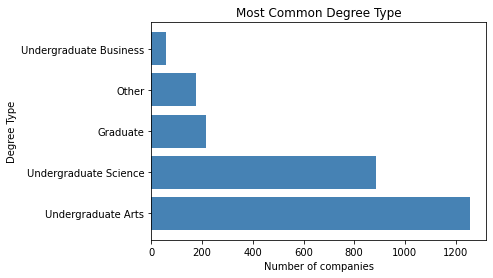

In [48]:
#degree type visualization
Yf1 = Yf['most_common_degree_type']
x = Yf1.unique()
y = Yf1.value_counts()
for i in range(5):
    plt.barh(x[i],y[i],color='steelblue')

#plt.xticks(rotation='vertical')
plt.title('Most Common Degree Type')
plt.xlabel('Number of companies'), plt.ylabel('Degree Type')
plt.show()

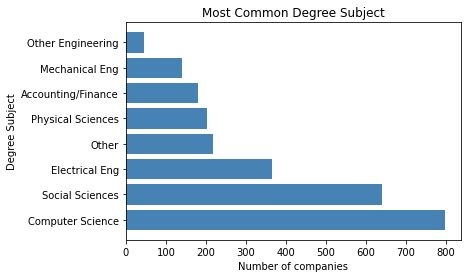

In [49]:
#degree subject visualization
Yf1 = Yf['most_common_degree_subject']
x = Yf1.unique()
y = Yf1.value_counts()
for i in range(8):
    plt.barh(x[i],y[i],color='steelblue')
#plt.xticks(rotation='vertical')
plt.title('Most Common Degree Subject')
plt.xlabel('Number of companies'), plt.ylabel('Degree Subject')
plt.show()

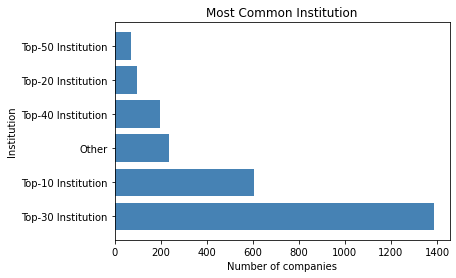

In [50]:
#institution type visualization
Yf1 = Yf['most_common_institution']
x = Yf1.unique()
y = Yf1.value_counts()
for i in range(6):
    plt.barh(x[i],y[i],color='steelblue')
#plt.xticks(rotation='vertical')
plt.title('Most Common Institution')
plt.xlabel('Number of companies'), plt.ylabel('Institution')
plt.show()

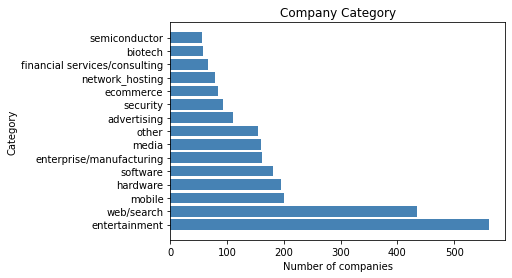

In [51]:
#category visualization
Yf1 = Yf['category']
x = Yf1.unique()
y = Yf1.value_counts()
for i in range(15):
    plt.barh(x[i],y[i],color='steelblue')
#plt.xticks(rotation='vertical')
plt.title('Company Category')
plt.xlabel('Number of companies'), plt.ylabel('Category')
plt.show()

### Final dataframe

In [76]:
df = Yf.drop(columns=['company_id'])
df = pd.get_dummies(df)
df.reset_index(inplace=True,drop=True)
df

,funding_rounds,total_funding,valuation,most_common_degree_type_Graduate,most_common_degree_type_Other,most_common_degree_type_Undergraduate Arts,most_common_degree_type_Undergraduate Business,most_common_degree_type_Undergraduate Science,most_common_degree_subject_Accounting/Finance,most_common_degree_subject_Computer Science,...,category_semiconductor,category_software,category_web/search,state_Mid-Atlantic,state_Midwest,state_Northeast,state_Pacific,state_South,state_Southwest,state_West
0,0,0.0,2.000000e+07,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0.0,0.000000e+00,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2589,1,12500000.0,1.000000e+09,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2590,5,96627980.0,2.550000e+09,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [77]:
#list of the predictors
print(df.columns.tolist())

['funding_rounds', 'total_funding', 'valuation', 'most_common_degree_type_Graduate', 'most_common_degree_type_Other', 'most_common_degree_type_Undergraduate Arts', 'most_common_degree_type_Undergraduate Business', 'most_common_degree_type_Undergraduate Science', 'most_common_degree_subject_Accounting/Finance', 'most_common_degree_subject_Computer Science', 'most_common_degree_subject_Electrical Eng', 'most_common_degree_subject_Mechanical Eng', 'most_common_degree_subject_Other', 'most_common_degree_subject_Other Engineering', 'most_common_degree_subject_Physical Sciences', 'most_common_degree_subject_Social Sciences', 'most_common_institution_Other', 'most_common_institution_Top-10 Institution', 'most_common_institution_Top-20 Institution', 'most_common_institution_Top-30 Institution', 'most_common_institution_Top-40 Institution', 'most_common_institution_Top-50 Institution', 'category_advertising', 'category_biotech', 'category_ecommerce', 'category_enterprise/manufacturing', 'catego

### Linear regression for valuation

In [106]:
df1 = df.copy()

In [107]:
valuation = df1['valuation']
df1.drop('valuation', inplace=True, axis=1)
df1 = sm.add_constant(df1)
# predictors = sm.add_constant(df1)

model = sm.OLS(valuation, df1)
results = model.fit()

# Print out the stats
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              valuation   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.251
Date:                Thu, 20 May 2021   Prob (F-statistic):              0.140
Time:                        17:46:45   Log-Likelihood:                -67542.
No. Observations:                2591   AIC:                         1.352e+05
Df Residuals:                    2552   BIC:                         1.354e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                           1.558e+09   1.74e+09      0.896      0.370   -1.85e+09    4.97e+09
funding_rounds                                 -7.001e+08    6.7e+08     -1.045      0.296   -2.01e+09    6.14e+08
total_funding                                      6.7073      7.836      0.856      0.392      -8.657      22.072
most_common_degree_type_Graduate                1.368e+09   3.27e+09      0.418      0.676   -5.05e+09    7.79e+09
most_common_degree_type_Other                   5.831e+08   3.54e+09      0.165      0.869   -6.35e+09    7.52e+09
most_common_degree_type_Undergraduate Arts      3.218e+08   2.21e+09      0.145      0.884   -4.02e+09    4.66e+09
most_common_degree_type_Undergraduate Business -3.714e+09   5.89e+09     -0.630      0.529   -1.53e+10    7.84e+09
most_common_degree_type_Undergraduate Science   2.999e+09   2.03e+09      1.479      0.139   -9.76e+08    6.97e+09
most_common_degree_subject_Accounting/Finance  -3.276e+08    3.4e+09     -0.096      0.923   -6.99e+09    6.33e+09
most_common_degree_subject_Computer Science    -1.531e+08   2.32e+09     -0.066      0.947    -4.7e+09    4.39e+09
most_common_degree_subject_Electrical Eng       -8.34e+08   3.57e+09     -0.234      0.815   -7.84e+09    6.17e+09
most_common_degree_subject_Mechanical Eng       9.376e+06   6.83e+09      0.001      0.999   -1.34e+10    1.34e+10
most_common_degree_subject_Other                3.049e+09   2.11e+09      1.442      0.149    -1.1e+09     7.2e+09
most_common_degree_subject_Other Engineering   -7.539e+08   3.62e+09     -0.208      0.835   -7.85e+09    6.34e+09
most_common_degree_subject_Physical Sciences   -3.153e+07   4.32e+09     -0.007      0.994   -8.49e+09    8.43e+09
most_common_degree_subject_Social Sciences      5.992e+08   2.88e+09      0.208      0.835   -5.06e+09    6.26e+09
most_common_institution_Other                  -1.824e+09   1.89e+09     -0.966      0.334   -5.53e+09    1.88e+09
most_common_institution_Top-10 Institution     -1.501e+08   2.33e+09     -0.064      0.949   -4.71e+09    4.41e+09
most_common_institution_Top-20 Institution      1.033e+10   3.19e+09      3.239      0.001    4.07e+09    1.66e+10
most_common_institution_Top-30 Institution     -1.035e+09   3.41e+09     -0.303      0.762   -7.72e+09    5.65e+09
most_common_institution_Top-40 Institution     -1.916e+09    5.3e+09     -0.361      0.718   -1.23e+10    8.48e+09
most_common_institution_Top-50 Institution     -3.843e+09    4.6e+09     -0.836      0.403   -1.29e+10    5.17e+09
category_advertising                           -5.002e+08      4e+09     -0.125      0.900   -8.33e+09    7.33e+09
category_biotech                                3.397e+08   3.93e+09      0.086      0.931   

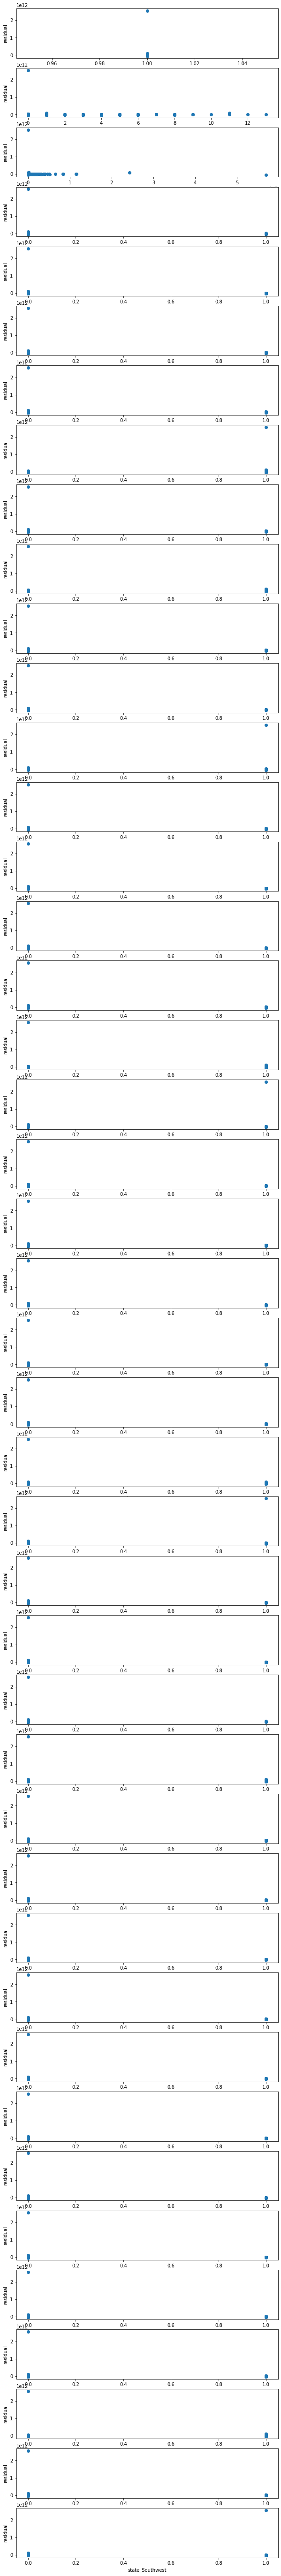

In [108]:
fig, ax = plt.subplots(43,figsize =(10,100))
resid = results.resid
for i in range(43): # for each of the 43 variables
  # create a fitted plot for that variable ('i' indexes the variables)
  ax[i].scatter(df1.iloc[:,i],resid) 
  ax[i].set_xlabel(df1.columns[i]) 
  ax[i].set_ylabel("residual")

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([-1.13180177e-03,  6.56078491e-03,  1.35013406e-04,  2.76166593e-03,
        -6.61237386e-03,  5.77711511e-04, -6.32723528e-03, -4.33413315e-04,
         2.42244673e-03, -1.21219831e-02,  1.00000000e+00, -1.21219831e-02,
         2.42244673e-03, -4.33413315e-04, -6.32723528e-03,  5.77711511e-04,
        -6.61237386e-03,  2.76166593e-03,  1.35013406e-04,  6.56078491e-03,
        -1.13180177e-03]),
 <matplotlib.lines.Line2D at 0x1dad4ce69c8>)

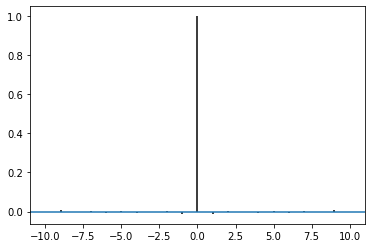

In [109]:
# Code for autocorrelation plot
plt.acorr(resid)

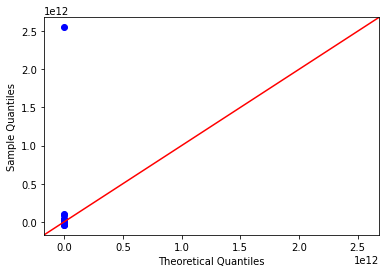

In [110]:
sm.qqplot(resid, line='45');

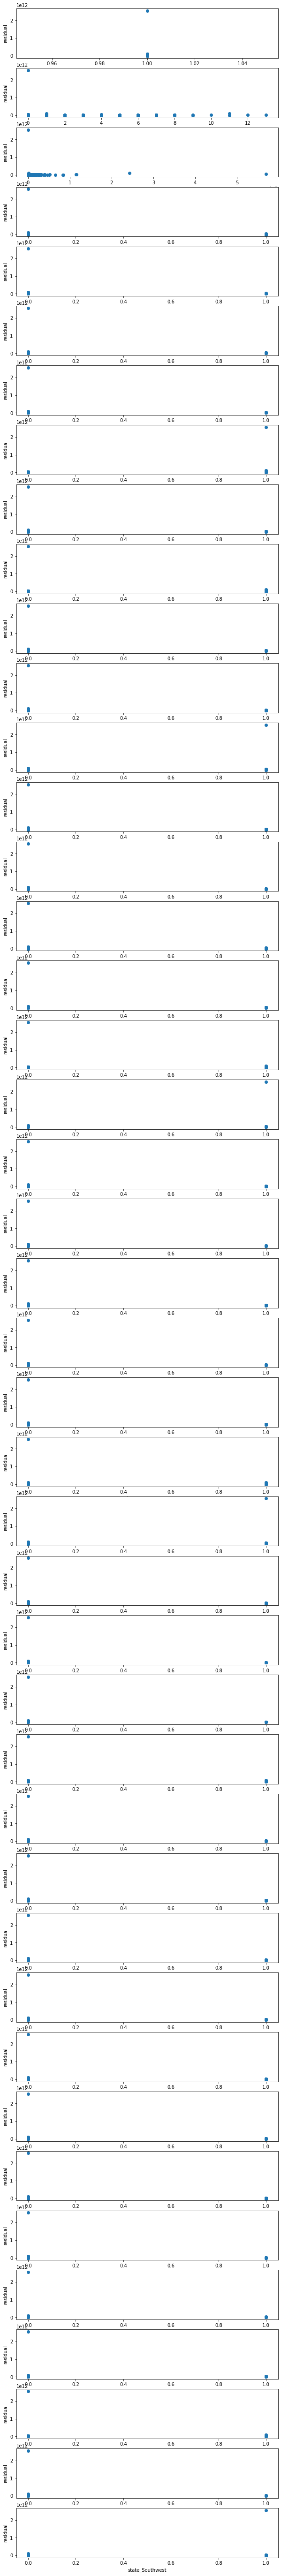

In [111]:
#checking for non-constant variance
fig, ax = plt.subplots(43,figsize =(10,100))
for i in range(43): # for each of the 43 variables
  # create a fitted plot for that variable ('i' indexes the variables)
  ax[i].scatter(df1.iloc[:,i],np.abs(resid)) 
  ax[i].set_xlabel(df1.columns[i]) 
  ax[i].set_ylabel("residual")

### Model Selection by Minimizing AIC

In [112]:
df_aic = df.copy()

In [113]:
Yaic = df_aic['valuation']
df_aic.drop('valuation', inplace=True, axis=1)
X = sm.add_constant(df_aic)

X_train, X_test, y_train, y_test = train_test_split(X,Yaic, test_size = 0.25, random_state = 0)

C:\Users\lukef\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [88]:
# Using the minAIC function from recitation 7

def minAIC(X,y):
    variables = X.columns
    model = sm.OLS(y,X[variables]).fit()
    while True:
        maxp = np.max(model.pvalues)
        new_variables = variables[model.pvalues < maxp]
        newmodel = sm.OLS(y,X[new_variables]).fit()
        if newmodel.aic < model.aic:
            print('here')
            model = newmodel
            variables = new_variables
        else:
            break
    return model,variables

# select on training set 
model,variables = minAIC(X_train, y_train)
print(variables)


y_pred = model.predict(X_test[variables])
print(mean_squared_error(y_test,y_pred))

Index(['const', 'funding_rounds', 'total_funding',
       'most_common_degree_type_Graduate', 'most_common_degree_type_Other',
       'most_common_degree_type_Undergraduate Arts',
       'most_common_degree_type_Undergraduate Business',
       'most_common_degree_type_Undergraduate Science',
       'most_common_degree_subject_Accounting/Finance',
       'most_common_degree_subject_Computer Science',
       'most_common_degree_subject_Electrical Eng',
       'most_common_degree_subject_Mechanical Eng',
       'most_common_degree_subject_Other',
       'most_common_degree_subject_Other Engineering',
       'most_common_degree_subject_Physical Sciences',
       'most_common_degree_subject_Social Sciences',
       'most_common_institution_Other',
       'most_common_institution_Top-10 Institution',
       'most_common_institution_Top-20 Institution',
       'most_common_institution_Top-30 Institution',
       'most_common_institution_Top-40 Institution',
       'most_common_institution_Top

In [89]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              valuation   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.279
Date:                Thu, 20 May 2021   Prob (F-statistic):              0.119
Time:                        17:20:24   Log-Likelihood:                -50923.
No. Observations:                1943   AIC:                         1.019e+05
Df Residuals:                    1904   BIC:                         1.021e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                           2.357e+09   2.35e+09      1.002      0.316   -2.26e+09    6.97e+09
funding_rounds                                 -9.364e+08    8.9e+08     -1.052      0.293   -2.68e+09    8.09e+08
total_funding                                      6.8954      9.271      0.744      0.457     -11.287      25.077
most_common_degree_type_Graduate                1.455e+09   4.34e+09      0.336      0.737   -7.05e+09    9.96e+09
most_common_degree_type_Other                   4.904e+08   4.66e+09      0.105      0.916   -8.65e+09    9.63e+09
most_common_degree_type_Undergraduate Arts      1.925e+08   2.94e+09      0.066      0.948   -5.57e+09    5.95e+09
most_common_degree_type_Undergraduate Business -3.422e+09   7.78e+09     -0.440      0.660   -1.87e+10    1.18e+10
most_common_degree_type_Undergraduate Science    3.64e+09   2.68e+09      1.356      0.175   -1.62e+09     8.9e+09
most_common_degree_subject_Accounting/Finance  -9.522e+08   4.69e+09     -0.203      0.839   -1.01e+10    8.24e+09
most_common_degree_subject_Computer Science    -3.521e+08   3.06e+09     -0.115      0.908   -6.35e+09    5.65e+09
most_common_degree_subject_Electrical Eng      -9.188e+08   4.69e+09     -0.196      0.845   -1.01e+10    8.28e+09
most_common_degree_subject_Mechanical Eng           1e+09   9.07e+09      0.110      0.912   -1.68e+10    1.88e+10
most_common_degree_subject_Other                4.388e+09   2.83e+09      1.550      0.121   -1.16e+09    9.94e+09
most_common_degree_subject_Other Engineering   -1.379e+09   4.83e+09     -0.285      0.775   -1.08e+10    8.09e+09
most_common_degree_subject_Physical Sciences   -4.215e+07   5.56e+09     -0.008      0.994   -1.09e+10    1.09e+10
most_common_degree_subject_Social Sciences      6.127e+08   3.83e+09      0.160      0.873   -6.89e+09    8.12e+09
most_common_institution_Other                  -2.307e+09   2.55e+09     -0.905      0.366   -7.31e+09    2.69e+09
most_common_institution_Top-10 Institution     -3.079e+08    3.1e+09     -0.099      0.921   -6.39e+09    5.77e+09
most_common_institution_Top-20 Institution      1.344e+10   4.26e+09      3.155      0.002    5.08e+09    2.18e+10
most_common_institution_Top-30 Institution     -1.547e+09   4.55e+09     -0.340      0.734   -1.05e+10    7.39e+09
most_common_institution_Top-40 Institution     -3.302e+09   7.45e+09     -0.443      0.658   -1.79e+10    1.13e+10
most_common_institution_Top-50 Institution     -3.618e+09   6.12e+09     -0.591      0.555   -1.56e+10    8.39e+09
category_advertising                           -4.542e+08   5.43e+09     -0.084      0.933   -1.11e+10    1.02e+10
category_biotech                                4.284e+08   5.06e+09      0.085      0.932   

In [114]:
covars = X.columns

In [125]:
sig_vars = covars

In [126]:
sig_vars = sig_vars[results.pvalues <= 0.05]
model2 = sm.OLS(y_train,X_train[sig_vars]).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              valuation   R-squared (uncentered):                   0.022
Model:                            OLS   Adj. R-squared (uncentered):              0.020
Method:                 Least Squares   F-statistic:                              14.23
Date:                Thu, 20 May 2021   Prob (F-statistic):                    3.59e-09
Time:                        17:48:38   Log-Likelihood:                         -50927.
No. Observations:                1943   AIC:                                  1.019e+05
Df Residuals:                    1940   BIC:                                  1.019e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
most_common_institution_Top-20 Institution    1.3e+10   4.43e+09      2.932      0.003    4.31e+09    2.17e+10
category_enterprise/manufacturing           1.379e+10   4.86e+09      2.840      0.005    4.27e+09    2.33e+10
state_Southwest                             2.856e+10   6.34e+09      4.505      0.000    1.61e+10     4.1e+10
==============================================================================
Omnibus:                     5859.322   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        278642024.696
Skew:                          42.594   Prob(JB):                         0.00
Kurtosis:                    1856.251   Cond. No.                         1.50
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [128]:
y_pred = model2.predict(X_test[sig_vars])
print(mean_squared_error(y_test,y_pred))

8.639315878386844e+19


In [129]:
model_full = sm.OLS(y_train,X_train).fit()

In [130]:
y_pred = model_full.predict(X_test)
print(mean_squared_error(y_test,y_pred))

1.0279392752981357e+20


### Logistic regression for valuation

In [54]:
df2 = df.copy()
df2['valuation'] = np.where(df2['valuation'].between(1,999999999), 1, df2['valuation'])
df2['valuation'] = np.where(df2['valuation'] >= 1000000000, 2, df2['valuation'])

df2['valuation'] = df2['valuation'].replace(0,'Failure')
df2['valuation'] = df2['valuation'].replace(1,'Success')
df2['valuation'] = df2['valuation'].replace(2,'Unicorn')


df2['valuation'].value_counts()

Failure    1584
Success     858
Unicorn     149
Name: valuation, dtype: int64

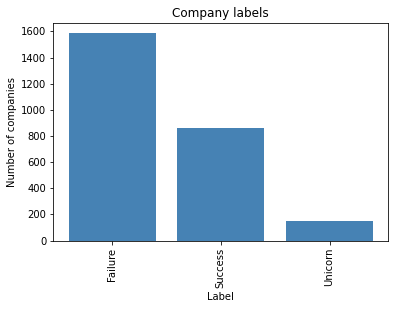

In [55]:
#log reg label visualization
#visualization for number of funding events in each round
y = df2['valuation']
x = ['Failure','Success','Unicorn']
y = y.value_counts()
for i in range(3):
    plt.bar(x[i],y[i],color='steelblue')
plt.xticks(rotation='vertical')
plt.title('Company labels')
plt.ylabel('Number of companies'), plt.xlabel('Label')
plt.show()

In [56]:
#predictors are all columns except valuation
X = df2
X = X.drop(columns=['valuation'])
X = sm.add_constant(X)
#Valuation is the outcome
Y = df2['valuation']

#test/train split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

C:\Users\lukef\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [57]:
logreg = LogisticRegression(fit_intercept=False,class_weight={'Unicorn': .1,'Success': .3,'Failure':.6}).fit(X_train,Y_train)
pred = logreg.predict(X_test)

train_score = logreg.score(X_train,Y_train)
print("training accuracy: ",train_score)
test_score = logreg.score(X_test,Y_test)
print("testing accuracy: ",test_score)

training accuracy:  0.6026762738033968
testing accuracy:  0.6373456790123457


C:\Users\lukef\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\lukef\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [58]:
cm = metrics.confusion_matrix(Y_test, pred)
print(cm)

[[413   0   0]
 [198   0   0]
 [ 37   0   0]]


Text(0.5, 1.0, "('Test Accuracy Score:', 0.6373456790123457)")

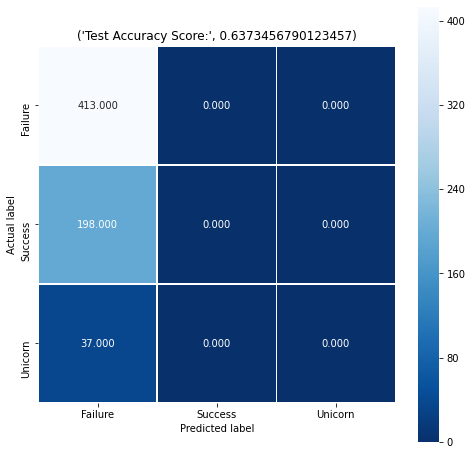

In [59]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
plt.figure(figsize=(8,8))
x_axis_labels = ['Failure', 'Success', 'Unicorn'];
y_axis_labels = ['Failure', 'Success', 'Unicorn'];
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r',xticklabels=x_axis_labels, yticklabels=y_axis_labels);

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
score = 'Test Accuracy Score:',test_score
plt.title(score)

In [60]:
bagging = BaggingClassifier(n_estimators=45,max_features=44,bootstrap_features=True,random_state=14).fit(X_train, Y_train)
pred = bagging.predict(X_test)

train_score = bagging.score(X_train,Y_train)
print("training accuracy: ",train_score)
test_score = bagging.score(X_test,Y_test)
print("testing accuracy: ",test_score)




training accuracy:  0.9382398353062275
testing accuracy:  0.6358024691358025


In [61]:
cm = metrics.confusion_matrix(Y_test, pred)
print(cm)

[[360  51   2]
 [146  48   4]
 [ 27   6   4]]


Text(0.5, 1.0, "('Test Accuracy Score:', 0.6358024691358025)")

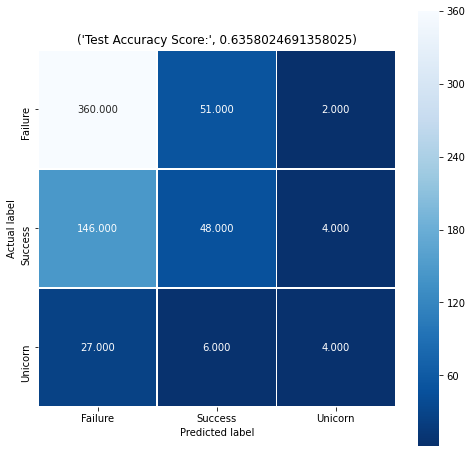

In [62]:
# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
plt.figure(figsize=(8,8))
x_axis_labels = ['Failure', 'Success', 'Unicorn'];
y_axis_labels = ['Failure', 'Success', 'Unicorn'];
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r',xticklabels=x_axis_labels, yticklabels=y_axis_labels);

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
score = 'Test Accuracy Score:',test_score
plt.title(score)

<br>
<br>
<br>
<br>
<br>
### Funding amount by investment round dataframe

In [63]:
#create df with company id, funding round type, funding round amount, and valuation pre that funding round
dfx = rounds[rounds['object_id'].isin(list(Yf['company_id']))]
dfx = dfx[['object_id','funding_round_code','raised_amount_usd','participants','pre_money_valuation_usd']]
dfx.columns = ['id','funding_round_code','funding_round_amount','participants','pre_money_valuation']
dfx.reset_index(inplace=True, drop=True)

In [64]:
#merge predictors with funding rounds and funding per round
Yfm = Yf.merge(dfx,left_on='company_id',right_on='id')
Yfm = Yfm.drop(columns=['valuation','total_funding','funding_rounds','id'])
Yfm = Yfm[['company_id','funding_round_code','most_common_degree_type','most_common_degree_subject','most_common_institution','category','state','participants','pre_money_valuation','funding_round_amount']]
Yfm.columns = ['company_id','funding_round','most_common_degree_type','most_common_degree_subject','most_common_institution','category','state','participants','pre_money_valuation','funding_round_amount']

### Split dataframe by funding round to predict funding round amount

In [65]:
Yfm['funding_round'] = Yfm['funding_round'].replace('angel','Angel Investment')
Yfm['funding_round'] = Yfm['funding_round'].replace('seed','Seed Round')
Yfm['funding_round'] = Yfm['funding_round'].replace('a','Series A')
Yfm['funding_round'] = Yfm['funding_round'].replace('b','Series B')
Yfm['funding_round'] = Yfm['funding_round'].replace('c','Series C')
Yfm['funding_round'] = Yfm['funding_round'].replace(['d','private_equity','e','f','g'],'Late Stage Investment')

# for inst in Yfm['funding_round'].unique():
#     if inst not in ['Top-10 Institution','Top-20 Institution','Top-30 Institution','Top-40 Institution','Top-50 Institution']:
#         Yfm['funding_round'] = Yfm['funding_round'].replace(inst,'Other')
listz = ['Angel Investment','Seed Round','Series A','Series B','Series C','Late Stage Investment']
Yfm = Yfm[Yfm['funding_round'].isin(listz)]

Yfm = Yfm.drop(columns=['company_id'])
Yfm.reset_index(inplace=True,drop=True)

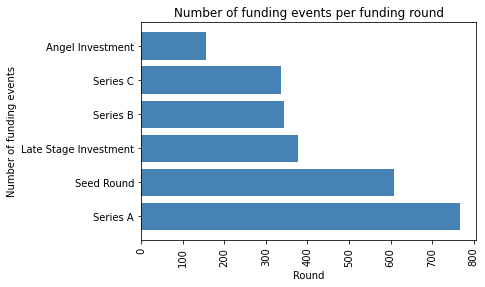

In [75]:
#visualization for number of funding events in each round
y = Yfm['funding_round']
x = y.unique()
y = y.value_counts()
for i in range(6):
    plt.barh(x[i],y[i],color='steelblue')
plt.xticks(rotation='vertical')
plt.title('Number of funding events per funding round')
plt.ylabel('Number of funding events'), plt.xlabel('Round')
plt.show()

In [67]:
#create tables for each round; separate predictors from outcome
angel = Yfm[Yfm['funding_round']=='Angel Investment']
angel.reset_index(inplace=True,drop=True)
angel = angel.drop(columns='funding_round')
angel = pd.get_dummies(angel)
X1 = angel.drop(columns=['funding_round_amount'])
X1 = sm.add_constant(X1)
Y1 = angel['funding_round_amount']

seed = Yfm[Yfm['funding_round']=='Seed Round']
seed.reset_index(inplace=True,drop=True)
seed = seed.drop(columns='funding_round')
seed = pd.get_dummies(seed)
X2 = seed.drop(columns=['funding_round_amount'])
X2 = sm.add_constant(X2)
Y2 = seed['funding_round_amount']

seriesa = Yfm[Yfm['funding_round']=='Series A']
seriesa.reset_index(inplace=True,drop=True)
seriesa = seriesa.drop(columns='funding_round')
seriesa = pd.get_dummies(seriesa)
X3 = seriesa.drop(columns=['funding_round_amount'])
X3 = sm.add_constant(X3)
Y3 = seriesa['funding_round_amount']

seriesb = Yfm[Yfm['funding_round']=='Series B']
seriesb.reset_index(inplace=True,drop=True)
seriesb = seriesb.drop(columns='funding_round')
seriesb = pd.get_dummies(seriesb)
X4 = seriesb.drop(columns=['funding_round_amount'])
X4 = sm.add_constant(X4)
Y4 = seriesb['funding_round_amount']

seriesc = Yfm[Yfm['funding_round']=='Series C']
seriesc.reset_index(inplace=True,drop=True)
seriesc = seriesc.drop(columns='funding_round')
seriesc = pd.get_dummies(seriesc)
X5 = seriesc.drop(columns=['funding_round_amount'])
X5 = sm.add_constant(X5)
Y5 = seriesc['funding_round_amount']

late = Yfm[Yfm['funding_round']=='Late Stage Investment']
late.reset_index(inplace=True,drop=True)
late = late.drop(columns='funding_round')
late = pd.get_dummies(late)
X6 = late.drop(columns=['funding_round_amount'])
X6 = sm.add_constant(X6)
Y6 = late['funding_round_amount']

C:\Users\lukef\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [68]:
#create linreg for each model
model1 = sm.OLS(Y1, X1)
results1 = model1.fit()
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     funding_round_amount   R-squared:                       0.294
Model:                              OLS   Adj. R-squared:                  0.083
Method:                   Least Squares   F-statistic:                     1.390
Date:                  Thu, 20 May 2021   Prob (F-statistic):             0.0959
Time:                          11:12:39   Log-Likelihood:                -2387.0
No. Observations:                   157   AIC:                             4848.
Df Residuals:                       120   BIC:                             4961.
Df Model:                            36                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                           1.132e+06   2.03e+05      5.572      0.000     7.3e+05    1.53e+06
participants                                    2.574e+04   2.39e+04      1.077      0.284   -2.16e+04     7.3e+04
pre_money_valuation                                0.1394      0.222      0.628      0.531      -0.300       0.579
most_common_degree_type_Graduate                9.077e+04   3.26e+05      0.278      0.781   -5.55e+05    7.36e+05
most_common_degree_type_Other                  -5.181e+05   4.14e+05     -1.250      0.214   -1.34e+06    3.03e+05
most_common_degree_type_Undergraduate Arts     -2.089e+05   2.58e+05     -0.810      0.420    -7.2e+05    3.02e+05
most_common_degree_type_Undergraduate Business  2.339e+06   7.71e+05      3.035      0.003    8.13e+05    3.87e+06
most_common_degree_type_Undergraduate Science  -5.707e+05   2.57e+05     -2.219      0.028   -1.08e+06   -6.14e+04
most_common_degree_subject_Accounting/Finance  -4.996e+04   3.59e+05     -0.139      0.890   -7.62e+05    6.62e+05
most_common_degree_subject_Computer Science     2.306e+04   2.16e+05      0.107      0.915   -4.04e+05     4.5e+05
most_common_degree_subject_Electrical Eng       1.565e+05   3.84e+05      0.408      0.684   -6.03e+05    9.16e+05
most_common_degree_subject_Mechanical Eng        3.73e+05    6.3e+05      0.592      0.555   -8.75e+05    1.62e+06
most_common_degree_subject_Other                1.182e+05   2.14e+05      0.553      0.581   -3.05e+05    5.41e+05
most_common_degree_subject_Other Engineering    1.798e+05   4.58e+05      0.393      0.695   -7.26e+05    1.09e+06
most_common_degree_subject_Physical Sciences    2.755e+05   4.98e+05      0.553      0.581   -7.11e+05    1.26e+06
most_common_degree_subject_Social Sciences       5.61e+04   2.92e+05      0.192      0.848   -5.22e+05    6.34e+05
most_common_institution_Other                   3.251e+04   2.57e+05      0.127      0.899   -4.76e+05    5.41e+05
most_common_institution_Top-10 Institution     -3.281e+05   2.81e+05     -1.168      0.245   -8.84e+05    2.28e+05
most_common_institution_Top-20 Institution      3.509e+05   3.89e+05      0.901      0.369    -4.2e+05    1.12e+06
most_common_institution_Top-30 Institution      8.752e+05   4.25e+05      2.060      0.042    3.41e+04    1.72e+06
most_common_institution_Top-40 Institution     -8.338e+05   9.93e+05     -0.840      0.403    -2.8e+06    1.13e+06
most_common_institution_Top-50 Institution      1.036e+06   4.43e+05      2.335      0.021    1.57e+05    1.91e+06
category_advertising                            5.452e+05    3.8e+05      1.436      0.154   -2.07e+05     1.3e+06
category_ecommerce                             -3.323e+04   4.96e+05   

In [69]:
model2 = sm.OLS(Y2, X2)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     funding_round_amount   R-squared:                       0.125
Model:                              OLS   Adj. R-squared:                  0.022
Method:                   Least Squares   F-statistic:                     1.215
Date:                  Thu, 20 May 2021   Prob (F-statistic):              0.193
Time:                          11:12:39   Log-Likelihood:                -5497.6
No. Observations:                   344   AIC:                         1.107e+04
Df Residuals:                       307   BIC:                         1.121e+04
Df Model:                            36                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                           3.491e+05   2.37e+05      1.475      0.141   -1.17e+05    8.15e+05
participants                                    1.266e+04   3.74e+04      0.339      0.735   -6.09e+04    8.62e+04
pre_money_valuation                             7.088e-10   7.67e-10      0.925      0.356      -8e-10    2.22e-09
most_common_degree_type_Graduate                3.532e+05   4.61e+05      0.766      0.444   -5.54e+05    1.26e+06
most_common_degree_type_Other                  -9.667e+04   4.07e+05     -0.237      0.813   -8.98e+05    7.05e+05
most_common_degree_type_Undergraduate Arts     -1.195e+04   2.56e+05     -0.047      0.963   -5.15e+05    4.91e+05
most_common_degree_type_Undergraduate Business -3.005e+05   5.89e+05     -0.511      0.610   -1.46e+06    8.58e+05
most_common_degree_type_Undergraduate Science   4.051e+05   2.47e+05      1.641      0.102   -8.07e+04    8.91e+05
most_common_degree_subject_Accounting/Finance   5.486e+04   5.64e+05      0.097      0.923   -1.06e+06    1.17e+06
most_common_degree_subject_Computer Science     1.086e+05      3e+05      0.362      0.718   -4.82e+05    6.99e+05
most_common_degree_subject_Electrical Eng       2.393e+05   5.33e+05      0.449      0.653   -8.08e+05    1.29e+06
most_common_degree_subject_Mechanical Eng      -1.293e+06    1.2e+06     -1.075      0.283   -3.66e+06    1.07e+06
most_common_degree_subject_Other                2.308e+05   2.88e+05      0.802      0.423   -3.36e+05    7.97e+05
most_common_degree_subject_Other Engineering     7.01e+05   5.74e+05      1.222      0.223   -4.28e+05    1.83e+06
most_common_degree_subject_Physical Sciences    2.962e+05   5.89e+05      0.502      0.616   -8.64e+05    1.46e+06
most_common_degree_subject_Social Sciences      1.162e+04   3.78e+05      0.031      0.976   -7.33e+05    7.56e+05
most_common_institution_Other                    3.87e+05   2.33e+05      1.658      0.098   -7.23e+04    8.46e+05
most_common_institution_Top-10 Institution      4.106e+05   2.68e+05      1.529      0.127   -1.18e+05    9.39e+05
most_common_institution_Top-20 Institution      1.074e+05   3.69e+05      0.291      0.771   -6.18e+05    8.33e+05
most_common_institution_Top-30 Institution      4.193e+04   3.72e+05      0.113      0.910   -6.89e+05    7.73e+05
most_common_institution_Top-40 Institution      1.824e+04    5.9e+05      0.031      0.975   -1.14e+06    1.18e+06
most_common_institution_Top-50 Institution     -6.159e+05   5.01e+05     -1.230      0.219    -1.6e+06    3.69e+05
category_advertising                           -2.503e+05   4.75e+05     -0.527      0.599   -1.19e+06    6.85e+05
category_biotech                                6.127e+05   1.15e+06   

In [70]:
model3 = sm.OLS(Y3, X3)
results3 = model3.fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     funding_round_amount   R-squared:                       0.102
Model:                              OLS   Adj. R-squared:                  0.056
Method:                   Least Squares   F-statistic:                     2.187
Date:                  Thu, 20 May 2021   Prob (F-statistic):           6.71e-05
Time:                          11:12:40   Log-Likelihood:                -13383.
No. Observations:                   767   AIC:                         2.684e+04
Df Residuals:                       728   BIC:                         2.702e+04
Df Model:                            38                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                           2.852e+06   7.03e+05      4.057      0.000    1.47e+06    4.23e+06
participants                                    8.734e+04   1.58e+05      0.554      0.580   -2.22e+05    3.97e+05
pre_money_valuation                                0.0486      0.082      0.593      0.553      -0.112       0.210
most_common_degree_type_Graduate                5.778e+05   1.18e+06      0.491      0.624   -1.73e+06    2.89e+06
most_common_degree_type_Other                   1.514e+06   1.39e+06      1.090      0.276   -1.21e+06    4.24e+06
most_common_degree_type_Undergraduate Arts      1.082e+06   7.66e+05      1.413      0.158   -4.22e+05    2.59e+06
most_common_degree_type_Undergraduate Business -2.041e+06   2.15e+06     -0.949      0.343   -6.26e+06    2.18e+06
most_common_degree_type_Undergraduate Science   1.719e+06   7.37e+05      2.334      0.020    2.73e+05    3.17e+06
most_common_degree_subject_Accounting/Finance   3.378e+06   1.33e+06      2.541      0.011    7.68e+05    5.99e+06
most_common_degree_subject_Computer Science     8.623e+04   7.81e+05      0.110      0.912   -1.45e+06    1.62e+06
most_common_degree_subject_Electrical Eng       1.348e+06   1.21e+06      1.112      0.266   -1.03e+06    3.73e+06
most_common_degree_subject_Mechanical Eng      -1.758e+06   2.42e+06     -0.726      0.468   -6.51e+06    2.99e+06
most_common_degree_subject_Other                6.318e+04   7.75e+05      0.082      0.935   -1.46e+06    1.58e+06
most_common_degree_subject_Other Engineering    6.896e+05   1.25e+06      0.551      0.582   -1.77e+06    3.15e+06
most_common_degree_subject_Physical Sciences   -1.516e+06   1.61e+06     -0.942      0.346   -4.67e+06    1.64e+06
most_common_degree_subject_Social Sciences      5.614e+05   9.96e+05      0.564      0.573   -1.39e+06    2.52e+06
most_common_institution_Other                   1.876e+06   6.97e+05      2.693      0.007    5.08e+05    3.24e+06
most_common_institution_Top-10 Institution      2.552e+06   7.86e+05      3.248      0.001    1.01e+06     4.1e+06
most_common_institution_Top-20 Institution      1.806e+06   1.08e+06      1.675      0.094    -3.1e+05    3.92e+06
most_common_institution_Top-30 Institution      6.264e+05   1.13e+06      0.552      0.581    -1.6e+06    2.85e+06
most_common_institution_Top-40 Institution     -3.111e+06   1.96e+06     -1.589      0.112   -6.95e+06    7.32e+05
most_common_institution_Top-50 Institution     -8.973e+05   1.94e+06     -0.464      0.643    -4.7e+06     2.9e+06
category_advertising                           -4.233e+05   1.21e+06     -0.350      0.727    -2.8e+06    1.95e+06
category_biotech                                 9.77e+06   1.88e+06   

In [71]:
model4 = sm.OLS(Y4, X4)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     funding_round_amount   R-squared:                       0.213
Model:                              OLS   Adj. R-squared:                  0.160
Method:                   Least Squares   F-statistic:                     4.050
Date:                  Thu, 20 May 2021   Prob (F-statistic):           1.16e-13
Time:                          11:12:40   Log-Likelihood:                -10874.
No. Observations:                   608   AIC:                         2.183e+04
Df Residuals:                       569   BIC:                         2.200e+04
Df Model:                            38                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                           3.254e+06   1.29e+06      2.531      0.012    7.29e+05    5.78e+06
participants                                    1.997e+06   3.41e+05      5.855      0.000    1.33e+06    2.67e+06
pre_money_valuation                                0.0242      0.028      0.867      0.386      -0.031       0.079
most_common_degree_type_Graduate                 8.06e+05    2.1e+06      0.384      0.701   -3.32e+06    4.93e+06
most_common_degree_type_Other                   3.078e+06   2.43e+06      1.268      0.205   -1.69e+06    7.85e+06
most_common_degree_type_Undergraduate Arts      -9.64e+05   1.56e+06     -0.617      0.537   -4.03e+06     2.1e+06
most_common_degree_type_Undergraduate Business -6.529e+05   5.09e+06     -0.128      0.898   -1.06e+07    9.34e+06
most_common_degree_type_Undergraduate Science   9.872e+05   1.48e+06      0.667      0.505   -1.92e+06    3.89e+06
most_common_degree_subject_Accounting/Finance   2.372e+06   2.13e+06      1.113      0.266   -1.81e+06    6.56e+06
most_common_degree_subject_Computer Science     2.377e+05   1.37e+06      0.173      0.863   -2.46e+06    2.94e+06
most_common_degree_subject_Electrical Eng       2.131e+05   1.86e+06      0.115      0.909   -3.44e+06    3.87e+06
most_common_degree_subject_Mechanical Eng       6.005e+06   3.95e+06      1.521      0.129   -1.75e+06    1.38e+07
most_common_degree_subject_Other                5.485e+05   1.31e+06      0.420      0.675   -2.02e+06    3.11e+06
most_common_degree_subject_Other Engineering   -2.656e+06   2.17e+06     -1.222      0.222   -6.93e+06    1.61e+06
most_common_degree_subject_Physical Sciences   -3.328e+06   2.47e+06     -1.345      0.179   -8.19e+06    1.53e+06
most_common_degree_subject_Social Sciences     -1.383e+05   1.79e+06     -0.077      0.939   -3.66e+06    3.38e+06
most_common_institution_Other                   1.741e+06   1.17e+06      1.488      0.137   -5.58e+05    4.04e+06
most_common_institution_Top-10 Institution      5.052e+06    1.3e+06      3.888      0.000     2.5e+06     7.6e+06
most_common_institution_Top-20 Institution      9.772e+05   1.94e+06      0.504      0.614   -2.83e+06    4.78e+06
most_common_institution_Top-30 Institution     -7.571e+04   2.09e+06     -0.036      0.971   -4.18e+06    4.03e+06
most_common_institution_Top-40 Institution      -7.85e+06      3e+06     -2.620      0.009   -1.37e+07   -1.97e+06
most_common_institution_Top-50 Institution       3.41e+06   2.78e+06      1.227      0.220   -2.05e+06    8.87e+06
category_advertising                           -8.246e+05   2.19e+06     -0.377      0.707   -5.12e+06    3.47e+06
category_biotech                                1.078e+07   2.54e+06   

In [72]:
model5 = sm.OLS(Y5, X5)
results5 = model5.fit()
results5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     funding_round_amount   R-squared:                       0.416
Model:                              OLS   Adj. R-squared:                  0.350
Method:                   Least Squares   F-statistic:                     6.324
Date:                  Thu, 20 May 2021   Prob (F-statistic):           3.33e-22
Time:                          11:12:41   Log-Likelihood:                -6788.6
No. Observations:                   376   AIC:                         1.366e+04
Df Residuals:                       337   BIC:                         1.381e+04
Df Model:                            38                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                            7.65e+06   2.14e+06      3.567      0.000    3.43e+06    1.19e+07
participants                                    1.868e+06   4.37e+05      4.269      0.000    1.01e+06    2.73e+06
pre_money_valuation                                0.0148      0.001     12.087      0.000       0.012       0.017
most_common_degree_type_Graduate                1.211e+06   3.32e+06      0.365      0.715   -5.32e+06    7.74e+06
most_common_degree_type_Other                  -5.311e+05   4.08e+06     -0.130      0.897   -8.56e+06     7.5e+06
most_common_degree_type_Undergraduate Arts      1.133e+06   2.44e+06      0.465      0.643   -3.66e+06    5.93e+06
most_common_degree_type_Undergraduate Business  3.844e+06   7.82e+06      0.492      0.623   -1.15e+07    1.92e+07
most_common_degree_type_Undergraduate Science   1.993e+06   2.24e+06      0.891      0.373    -2.4e+06    6.39e+06
most_common_degree_subject_Accounting/Finance   1.815e+05   3.19e+06      0.057      0.955    -6.1e+06    6.46e+06
most_common_degree_subject_Computer Science     1.531e+05   2.08e+06      0.074      0.941   -3.93e+06    4.24e+06
most_common_degree_subject_Electrical Eng      -4.517e+06   2.62e+06     -1.722      0.086   -9.68e+06    6.43e+05
most_common_degree_subject_Mechanical Eng       6.923e+06   5.01e+06      1.381      0.168   -2.94e+06    1.68e+07
most_common_degree_subject_Other               -6.772e+05    2.1e+06     -0.323      0.747    -4.8e+06    3.44e+06
most_common_degree_subject_Other Engineering    9.447e+06   3.64e+06      2.595      0.010    2.29e+06    1.66e+07
most_common_degree_subject_Physical Sciences   -1.204e+06   4.43e+06     -0.272      0.786   -9.92e+06    7.51e+06
most_common_degree_subject_Social Sciences     -2.657e+06   3.17e+06     -0.837      0.403    -8.9e+06    3.59e+06
most_common_institution_Other                   1.628e+06   2.17e+06      0.750      0.454   -2.64e+06     5.9e+06
most_common_institution_Top-10 Institution      3.817e+06   2.33e+06      1.635      0.103   -7.74e+05    8.41e+06
most_common_institution_Top-20 Institution     -1.646e+06   3.23e+06     -0.510      0.610   -7.99e+06     4.7e+06
most_common_institution_Top-30 Institution      4.558e+06   3.63e+06      1.254      0.211   -2.59e+06    1.17e+07
most_common_institution_Top-40 Institution     -4.201e+06   7.36e+06     -0.571      0.568   -1.87e+07    1.03e+07
most_common_institution_Top-50 Institution      3.494e+06   5.47e+06      0.638      0.524   -7.27e+06    1.43e+07
category_advertising                           -4.807e+06   3.52e+06     -1.366      0.173   -1.17e+07    2.12e+06
category_biotech                                6.223e+06   3.57e+06   

In [73]:
model6 = sm.OLS(Y6, X6)
results6 = model6.fit()
results6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     funding_round_amount   R-squared:                       0.252
Model:                              OLS   Adj. R-squared:                  0.157
Method:                   Least Squares   F-statistic:                     2.649
Date:                  Thu, 20 May 2021   Prob (F-statistic):           2.42e-06
Time:                          11:12:42   Log-Likelihood:                -6487.8
No. Observations:                   337   AIC:                         1.305e+04
Df Residuals:                       298   BIC:                         1.320e+04
Df Model:                            38                                         
Covariance Type:              nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                           1.843e+07   9.99e+06      1.845      0.066   -1.23e+06    3.81e+07
participants                                    5.186e+06   1.34e+06      3.884      0.000    2.56e+06    7.81e+06
pre_money_valuation                                0.0040      0.111      0.036      0.971      -0.215       0.223
most_common_degree_type_Graduate                7.753e+06   1.36e+07      0.572      0.568   -1.89e+07    3.44e+07
most_common_degree_type_Other                   1.299e+07    1.9e+07      0.684      0.495   -2.44e+07    5.04e+07
most_common_degree_type_Undergraduate Arts     -1.637e+07    1.3e+07     -1.260      0.209   -4.19e+07     9.2e+06
most_common_degree_type_Undergraduate Business  1.015e+05   4.96e+07      0.002      0.998   -9.75e+07    9.77e+07
most_common_degree_type_Undergraduate Science   1.396e+07    1.2e+07      1.166      0.245   -9.61e+06    3.75e+07
most_common_degree_subject_Accounting/Finance  -2.168e+06   1.27e+07     -0.170      0.865   -2.73e+07    2.29e+07
most_common_degree_subject_Computer Science     1.224e+07   7.88e+06      1.553      0.122   -3.27e+06    2.78e+07
most_common_degree_subject_Electrical Eng      -8.511e+06   9.32e+06     -0.913      0.362   -2.68e+07    9.83e+06
most_common_degree_subject_Mechanical Eng       2.308e+07   1.45e+07      1.597      0.111   -5.37e+06    5.15e+07
most_common_degree_subject_Other               -1.073e+07   7.46e+06     -1.437      0.152   -2.54e+07    3.96e+06
most_common_degree_subject_Other Engineering    1.461e+06   1.47e+07      0.100      0.921   -2.74e+07    3.03e+07
most_common_degree_subject_Physical Sciences    6.445e+06   1.51e+07      0.427      0.670   -2.33e+07    3.62e+07
most_common_degree_subject_Social Sciences     -3.389e+06   1.05e+07     -0.322      0.748   -2.41e+07    1.73e+07
most_common_institution_Other                   9.662e+05   7.64e+06      0.127      0.899   -1.41e+07     1.6e+07
most_common_institution_Top-10 Institution      6.861e+06   8.24e+06      0.833      0.406   -9.36e+06    2.31e+07
most_common_institution_Top-20 Institution     -2.862e+06   1.13e+07     -0.253      0.800   -2.51e+07    1.94e+07
most_common_institution_Top-30 Institution      1.123e+07   1.24e+07      0.909      0.364   -1.31e+07    3.55e+07
most_common_institution_Top-40 Institution      1.253e+07   2.84e+07      0.441      0.659   -4.33e+07    6.84e+07
most_common_institution_Top-50 Institution      -1.03e+07   1.49e+07     -0.693      0.489   -3.95e+07    1.89e+07
category_advertising                            2.882e+07   1.67e+07      1.723      0.086    -4.1e+06    6.17e+07
category_biotech                               -1.571e+07   1.18e+07   